# Hierarchical Inference with Redshifts

This notebook outlines how to simultaneously derive population and individual redshift distributions from a given collection of redshift PDFs using some of the tools available in `frankenz`.

# Setup

In [1]:
from __future__ import print_function, division
import sys
import pickle
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
from six.moves import range

# import frankenz code
import frankenz

# plot in-line within the notebook
%matplotlib inline

np.random.seed(265)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'axes.titlepad': '15.0'})
rcParams.update({'font.size': 30})

# Data

For our proof-of-concept tests, we will use the same mock SDSS data as earlier.

In [3]:
downsample = 10  # downsampling the population
survey = pickle.load(open('../data/mock_sdss_cww_bpz.pkl', 'rb'))  # load data
types = survey.data['types'][::downsample]
templates = survey.data['templates'][::downsample]
redshifts = survey.data['redshifts'][::downsample]
mags = survey.data['refmags'][::downsample]
Nobs = len(types)

## Redshift Distribution

The redshift distribution of our sample is plotted below.

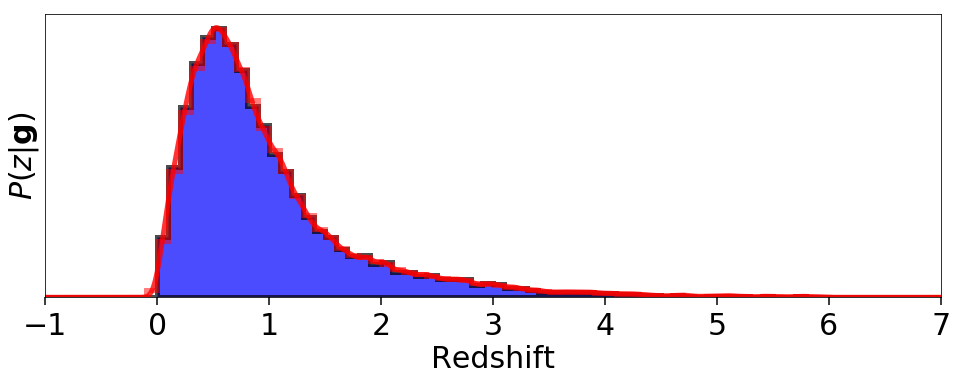

In [4]:
# histogram
dzbin = 0.1
zbins = np.arange(-1, 7.+1e-5, dzbin)  # redshift bins
zbins_mid = 0.5 * (zbins[1:] + zbins[:-1])  # bin midpoints
Nbins = len(zbins) - 1

# KDE
dzgrid = 0.01
zgrid = np.arange(-1., 7.+1e-5, dzgrid)
Ngrid, smooth = len(zgrid), 0.05
pdf = frankenz.pdf.gauss_kde(redshifts, np.ones(Nobs) * smooth, zgrid)
pdf /= np.trapz(pdf, zgrid)

# plotting
plt.figure(figsize=(14, 6))
plt.hist(redshifts, bins=zbins, histtype='stepfilled', lw=5,
         color='blue', alpha=0.7, density=True, edgecolor='black')
plt.plot(zgrid, pdf, lw=5, color='red', alpha=0.8)
plt.hist(zgrid + 1e-5, bins=zbins, weights=pdf, histtype='step', lw=5,
         color='red', alpha=0.5, density=True)
plt.xlabel('Redshift')
plt.xlim([zbins[0], zbins[-1]])
plt.yticks([])
plt.ylabel('$P(z|\mathbf{g})$')
plt.tight_layout()

## Redshift PDFs

For each object, we will generate Gaussian redshift PDFs with variable widths. As shown in the previous notebook, these satisfy all statistical constraints to be "PDFs" while remaining straightforward and easy to work with.

In [5]:
# generate Gaussian PDFs over grid
sigma = np.random.uniform(0.05, 0.2, size=Nobs)  # width
mu = np.random.normal(redshifts, sigma)  # noisy observation
zpdf = np.array([frankenz.pdf.gaussian(mu[i], sigma[i], zgrid) 
                 for i in range(Nobs)])  # redshift pdfs
zpdf /= np.trapz(zpdf, zgrid)[:,None]  # normalizing

# generate PDFs over bins
zpdf_bins = np.array([frankenz.pdf.gaussian_bin(mu[i], sigma[i], zbins) 
                      for i in range(Nobs)])  # redshift pdfs
zpdf_bins /= zpdf_bins.sum(axis=1)[:,None] * dzbin  # normalizing

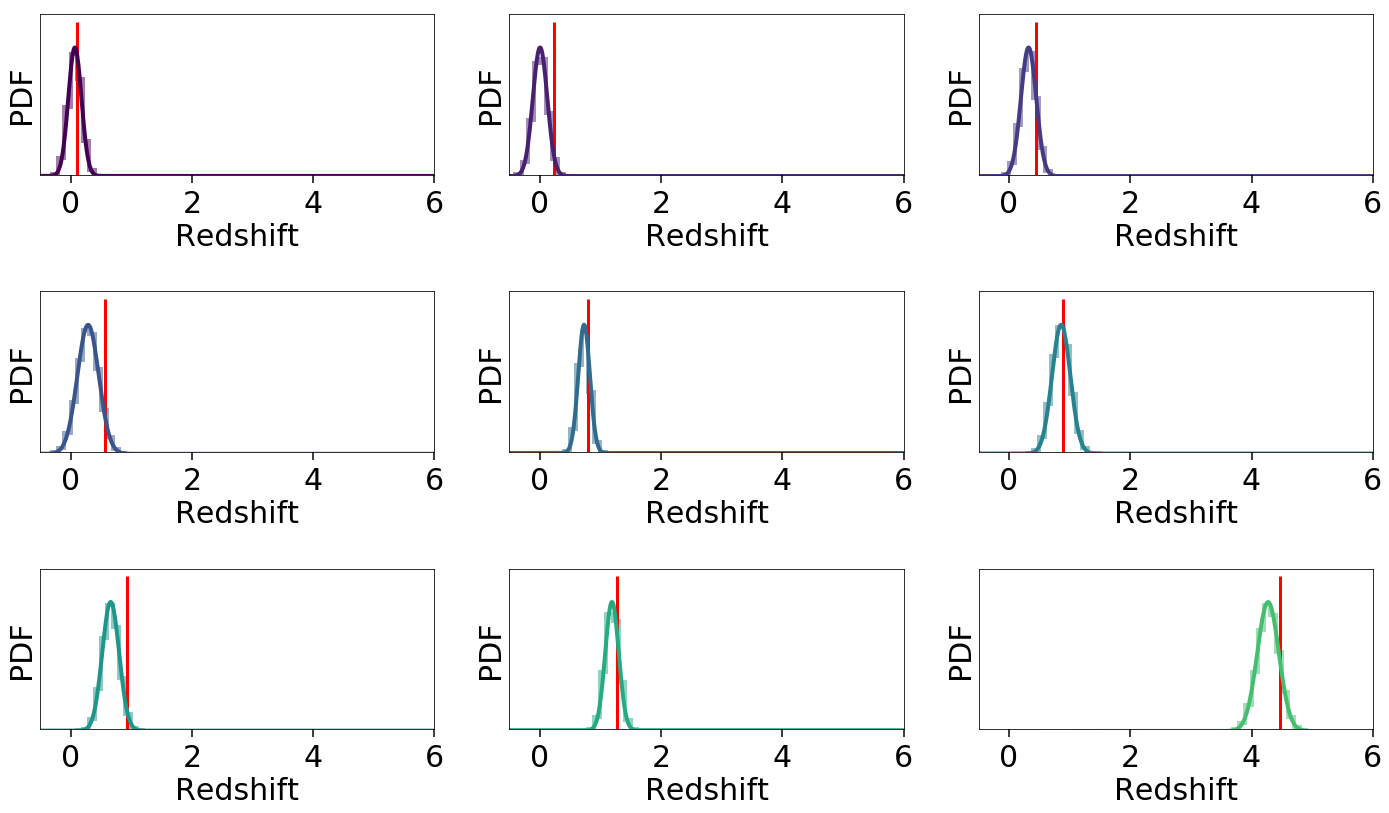

In [6]:
# plot some PDFs
plt.figure(figsize=(20, 12))
Nfigs = (3, 3)
Nplot = np.prod(Nfigs)
colors = plt.get_cmap('viridis')(np.linspace(0., 0.7, Nplot))
idxs = np.random.choice(Nobs, size=Nplot)
idxs = idxs[np.argsort(redshifts[idxs])]
for i, (j, c) in enumerate(zip(idxs, colors)):
    plt.subplot(Nfigs[0], Nfigs[1], i + 1)
    plt.plot(zgrid, zpdf[j], color=c, lw=4)
    plt.hist(zbins_mid, zbins, weights=zpdf_bins[j], 
             color=c, lw=4, alpha=0.5, histtype='step')
    plt.vlines(redshifts[j], 0., max(zpdf[j] * 1.2), color='red', 
               lw=3)
    plt.xlim([-0.5, 6])
    plt.ylim([0.03, None])
    plt.xlabel('Redshift')
    plt.yticks([])
    plt.ylabel('PDF')
    plt.tight_layout()

# Stacking PDFs

As discussed previously, for a sample with objects $g \in \mathbf{g}$ each with an associated redshift estimate $z_g$ with PDF $P(z_g | z)$, the posterior estimate for the population redshift distribution $P(z|\mathbf{g})$ can be written using using Bayes Theorem as

$$
P(\rho|\lbrace p_g \rbrace) \propto P(\lbrace p_g \rbrace | \rho) P(\rho) 
$$

where $\rho \equiv P(z|\mathbf{g})$ and $p_g \equiv P(z|g)$. Assuming independence, the first term becomes

$$
P(\lbrace p_g \rbrace | \rho) = \prod_{g} P(p_g|\rho) = \prod_g \int P(z_g|z) P(z|\mathbf{g}) dz
$$

In other words, the posterior probability for the population redshift distribution $P(z|\mathbf{g})$ is based on how much it overlaps the most with each of the individual redshift PDFs $P(z_g | z)$ (with some prior).

**This result means that the population distribution is _not_ what you get by stacking the individual redshift PDFs**:

$$ P(z|\mathbf{g}) \neq \frac{1}{N_\mathbf{g}}\sum_g P(z_g | z) $$

since there is no guarantee $\frac{1}{N_\mathbf{g}}\sum_g P(z_g | z)$ will maximize the posterior probability. This is demonstrated for us above.

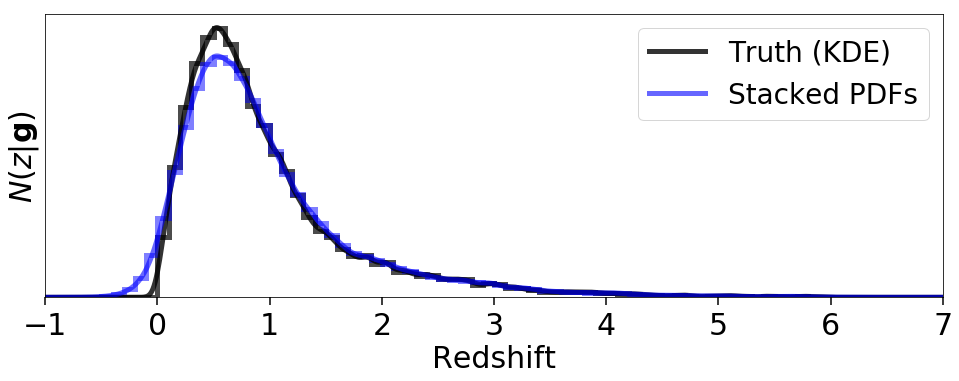

In [7]:
# plotting
plt.figure(figsize=(14, 6))
plt.plot(zgrid, pdf, lw=5, color='black', alpha=0.8,
         label='Truth (KDE)')
plt.plot(zgrid, zpdf.sum(axis=0) / Nobs, lw=5, color='blue',
         alpha=0.6, label='Stacked PDFs')
plt.hist(redshifts, bins=zbins, histtype='step', lw=5,
         color='black', alpha=0.7, density=True)
plt.hist(zbins_mid, bins=zbins, weights=zpdf_bins.sum(axis=0) / Nobs,
         histtype='step', lw=5,
         color='blue', alpha=0.5, density=True)
plt.xlabel('Redshift')
plt.xlim([zgrid[0], zgrid[-1]])
plt.yticks([])
plt.ylabel('$N(z|\mathbf{g})$')
plt.ylim([0., None])
plt.legend(fontsize=28, loc='best')
plt.tight_layout()

Intuitively, this just is telling us that we are dealing with a **deconvolution** problem -- we need to "take out" the error on the individual PDFs to get the population distribution right.

As discussed earlier, attempts to deal with this problem *after* stacking don't work. Three prototypical examples are shown below.

In [8]:
# number of samples
Nsamples = 500

## Poisson

In [9]:
# draw Poisson samples
pdf1 = zpdf_bins.sum(axis=0)  # stack PDFs
pdf1 /= pdf1.sum()  # normalize
pdf1 *= Nobs  # transform to counts
pdf1_samples = np.array([np.random.poisson(pdf1) 
                         for i in range(Nsamples)])  # draw samples

## Multinomial

In [10]:
# draw multinomial samples
pdf2_samples = np.random.multinomial(Nobs, pdf1 / pdf1.sum(),
                                     size=Nsamples)  # samples

## Individual PDF Draws

In [11]:
# draw posterior samples
pdf3_samples = np.zeros_like(pdf1_samples)
zpdf_norm = zpdf_bins / zpdf_bins.sum(axis=1)[:, None]
for j in range(Nsamples):
    if j % 50 == 0:
        sys.stderr.write(' {0}'.format(j))
    for i in range(Nobs):
        # stack categorial draw
        pdf3_samples[j] += np.random.multinomial(1, zpdf_norm[i])

 0 50 100 150 200 250 300 350 400 450

## Results

In [12]:
def zplot_bin(samples, label='type', color='blue', downsample=5):
    """Plot our binned draws."""
    [plt.hist(zbins_mid + 1e-5, zbins, 
              weights=samples[i], lw=3,
              histtype='step', color=color, alpha=0.05) 
     for i in np.arange(Nsamples)[::downsample]]
    plt.hist(zgrid, weights=pdf*1e-5, lw=3, histtype='step',
             color=color, alpha=0.6, label=label)
    h = plt.hist(redshifts, zbins, 
                 histtype='step', lw=6, color='black', alpha=0.7)
    plt.xlabel('Redshift')
    plt.xlim([-0.5, 4])
    plt.yticks([])
    plt.ylim([0, max(h[0]) * 1.2])
    plt.ylabel('$N(z|\mathbf{g})$')
    plt.legend(fontsize=26, loc='best')
    plt.tight_layout()
    
def cov_draws(samples, bin1=(14, 16), bin2=(16, 18), color='blue', 
              label='label', xlim=None, ylim=None):
    """Plot our draws within two bins."""

    # Bin results.
    n, _ = np.histogram(redshifts, bins=zbins)
    pdf_bin1 = n[bin1[0]:bin1[1]].sum() / n.sum() * Nobs / 1e3
    pdf_bin2 = n[bin2[0]:bin2[1]].sum() / n.sum() * Nobs / 1e3
    samples_bin1 = samples[:, bin1[0]:bin1[1]].sum(axis=1) / 1e3
    samples_bin2 = samples[:, bin2[0]:bin2[1]].sum(axis=1) / 1e3
    
    # Plot results.
    plt.vlines(pdf_bin1, 0, 100, lw=2, colors='black', linestyles='--')
    plt.hlines(pdf_bin2, 0, 100, lw=2, colors='black', linestyles='--')
    plt.plot(pdf_bin1, pdf_bin2, 's', color='black', markersize=20)
    plt.plot(samples_bin1, samples_bin2, 'o', color=color, 
             label=label, markersize=8, alpha=0.4)
    if xlim is None:
        plt.xlim([min(pdf_bin1, min(samples_bin1)) - 0.1, 
                  max(pdf_bin1, max(samples_bin1)) + 0.1])
    else:
        plt.xlim(xlim)
    if ylim is None:
        plt.ylim([min(pdf_bin2, min(samples_bin2)) - 0.1, 
                  max(pdf_bin2, max(samples_bin2)) + 0.1])
    else:
        plt.ylim(ylim)
    plt.xlabel(r'$N({:6.1f}\leq z < {:6.1f}) \quad [10^3]$'.format(zbins[bin1[0]], 
                                                           zbins[bin1[1]]))
    plt.ylabel(r'$N({:6.1f}\leq z < {:6.1f}) \quad [10^3]$'.format(zbins[bin2[0]], 
                                                           zbins[bin2[1]]))
    plt.legend(fontsize=28, loc=2)
    plt.tight_layout()

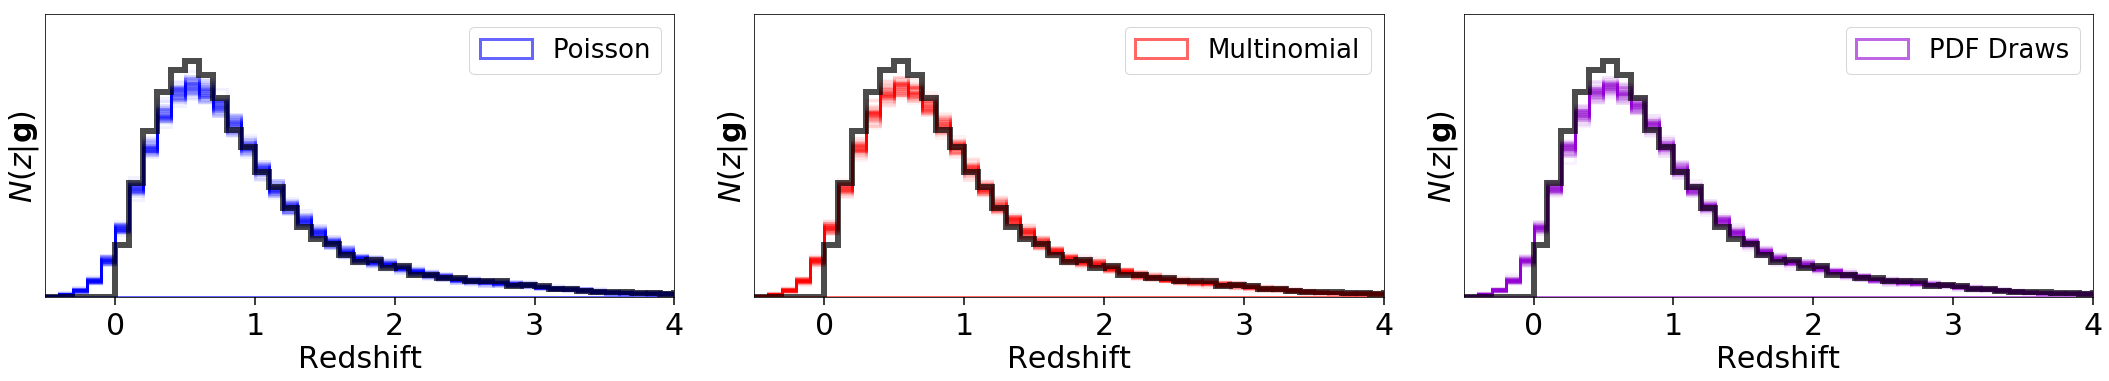

In [13]:
# plotting
plt.figure(figsize=(30, 6))
plt.subplot(1, 3, 1)
zplot_bin(pdf1_samples, label='Poisson', color='blue')
plt.subplot(1, 3, 2)
zplot_bin(pdf2_samples, label='Multinomial', color='red')
plt.subplot(1, 3, 3)
zplot_bin(pdf3_samples, label='PDF Draws', color='darkviolet')

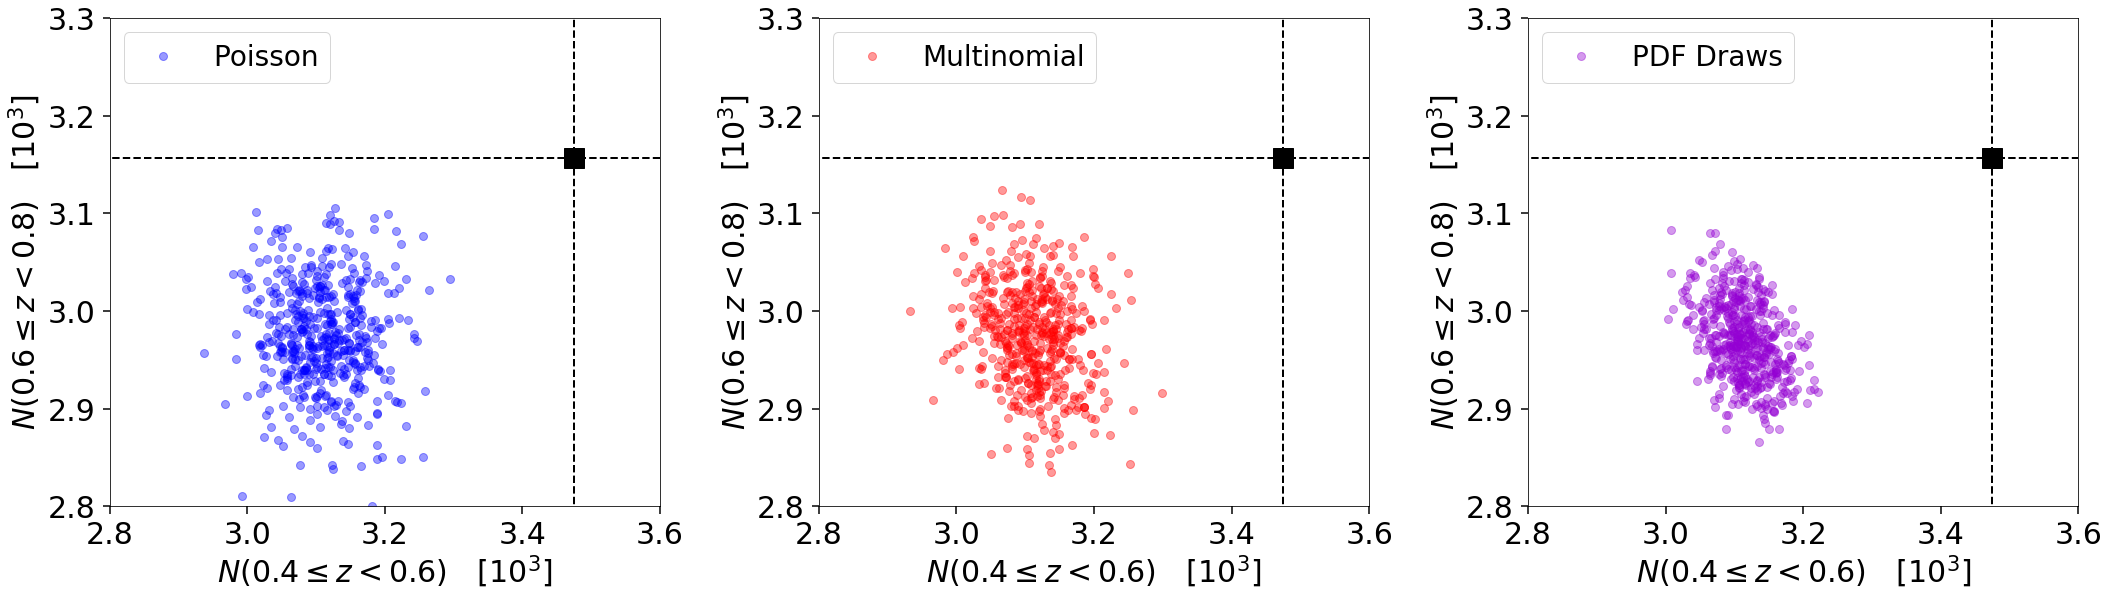

In [14]:
# plotting binned covariance
plt.figure(figsize=(30, 9))
plt.subplot(1, 3, 1)
cov_draws(pdf1_samples,
          xlim=(2.8, 3.6), ylim=(2.8, 3.3),
          color='blue', label='Poisson')
plt.subplot(1, 3, 2)
cov_draws(pdf2_samples,
          xlim=(2.8, 3.6), ylim=(2.8, 3.3),
          color='red', label='Multinomial')
plt.subplot(1, 3, 3)
cov_draws(pdf3_samples,
          xlim=(2.8, 3.6), ylim=(2.8, 3.3),
          color='darkviolet', label='PDF Draws')

# Population Modeling

As derived above and shown previously, the "right" thing to do is to sample from the posterior distribution:

$$
\ln P(\boldsymbol{\rho}|\lbrace \mathbf{p}_g \rbrace) = \ln P(\lbrace \mathbf{p}_g \rbrace | \boldsymbol{\rho}) + \ln P(p_\mathbf{g}) - \ln P(\lbrace \mathbf{p}_g \rbrace) = \sum_g \ln\left( \mathbf{p}_g \cdot \boldsymbol{\rho} \right) + \ln P(\boldsymbol{\rho}) - \ln P(\lbrace \mathbf{p}_g \rbrace)
$$

where $P(\lbrace \mathbf{p}_g \rbrace)$ is a constant that can be ignored and $\cdot$ is the dot product.

As before, we will take $P(\boldsymbol{\rho})$ to be a **Dirichlet** distribution:

$$ \boldsymbol{\rho} \sim {\rm Dir}\left(\mathbf{m} + \boldsymbol{\alpha}\right) $$

where $\boldsymbol{\alpha} = \mathbf{1}$ are a set of concentration parameters (with 1 being uniform) and $\mathbf{m}$ being a set of counts we've previously observed. We will prove this result later.

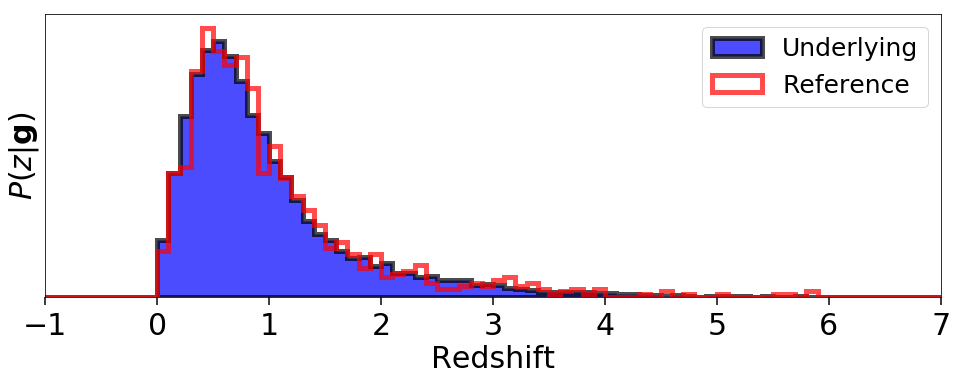

In [15]:
# grab representative set of previous redshifts
Nref = 1000
redshifts_ref = survey.data['redshifts'][-Nref:]
alpha = np.ones(Nbins)
counts_ref, _ = np.histogram(redshifts_ref, bins=zbins)

# plotting histogrammed representation
plt.figure(figsize=(14, 6))
plt.hist(redshifts, bins=zbins, histtype='stepfilled', lw=5,
         color='blue', alpha=0.7, density=True, edgecolor='black',
         label='Underlying')
plt.hist(redshifts_ref, bins=zbins, histtype='step', lw=5,
         color='red', alpha=0.7, density=True, label='Reference')
plt.xlabel('Redshift')
plt.xlim([zbins[0], zbins[-1]])
plt.yticks([])
plt.ylabel(r'$P(z|\mathbf{g})$')
plt.legend(fontsize='small')
plt.tight_layout()

In [16]:
from frankenz import samplers

# define our prior
def logprior(x, alpha=None, counts_ref=None):
    
    if alpha is None:
        alpha = np.ones_like(x)
    if counts_ref is None:
        counts_ref = np.zeros_like(x)
    if np.any(x < 0.):
        return -np.inf

    return scipy.stats.dirichlet.logpdf(x, alpha + counts_ref)

# initialize sampler
sampler_pop = samplers.population_sampler(zpdf_norm)

# run MH-in-Gibbs MCMC
Nburn = 100
sampler_pop.run_mcmc(Nsamples + Nburn, logprior_nz=logprior, prior_args=[alpha, counts_ref])

 Sample 600/600 [lnpost = -64343.189]      

In [17]:
# grab samples
pdf4_samples, pdf4_lnps = sampler_pop.results
pdf4_samples = pdf4_samples[-500:] * Nobs  # truncate and rescale

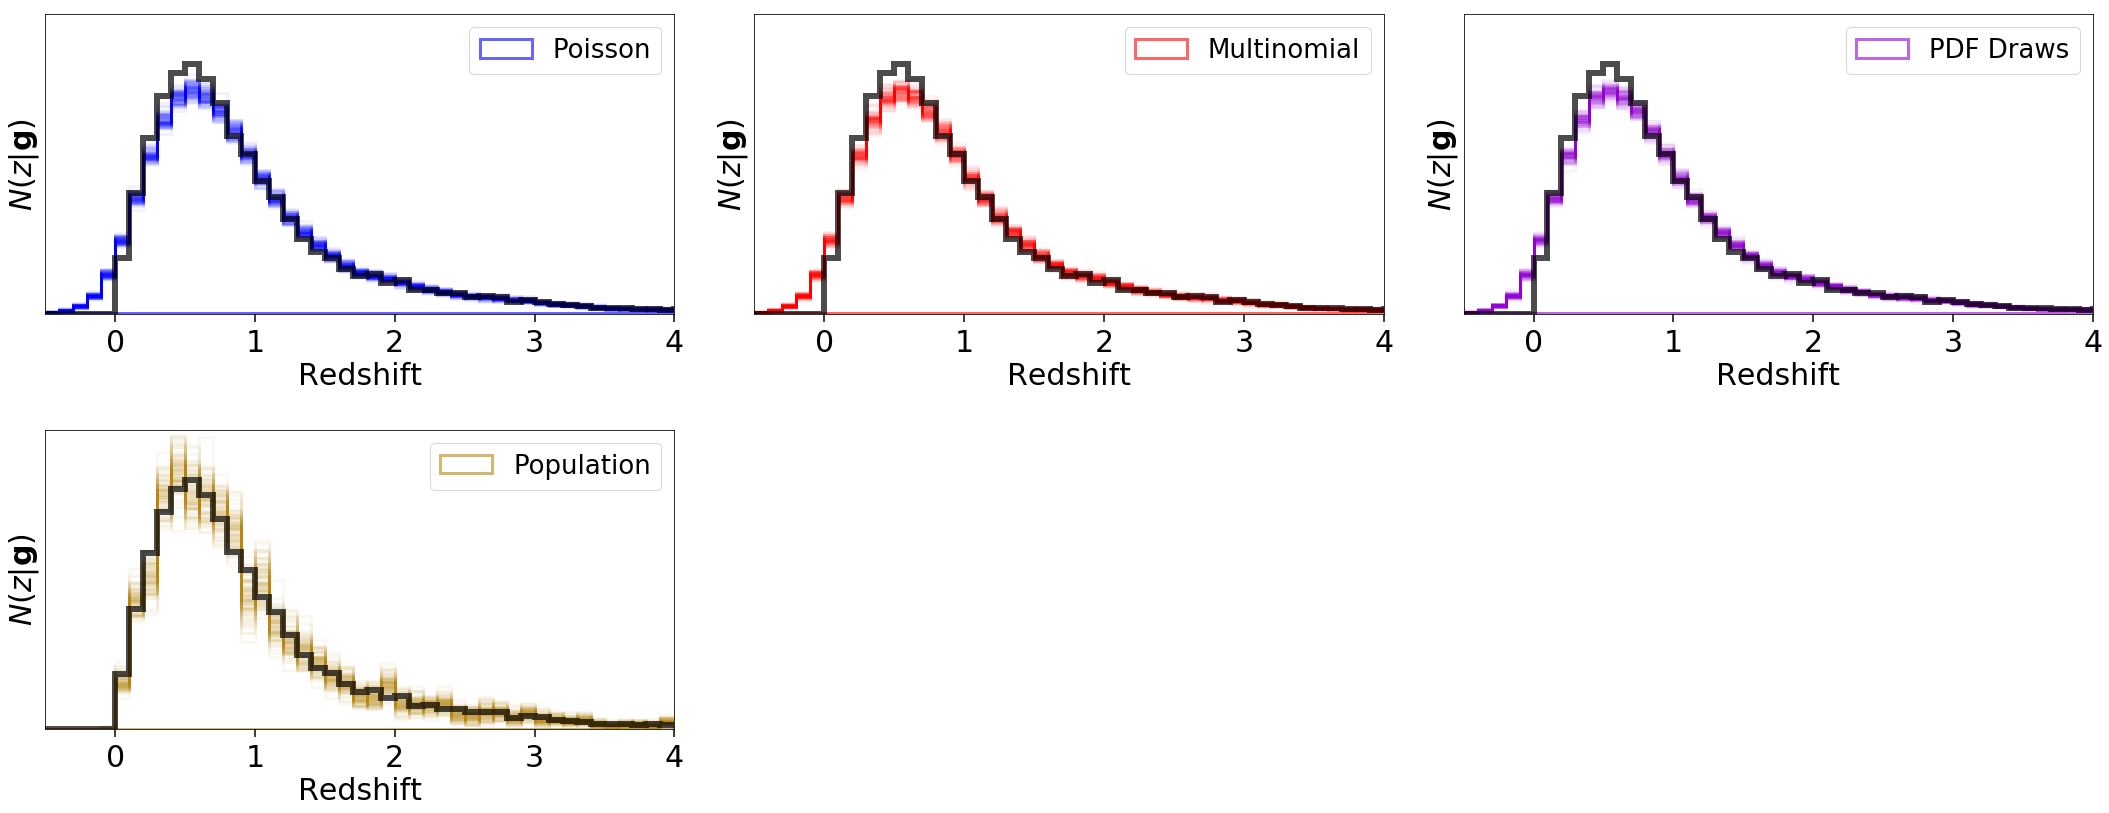

In [18]:
# plotting
plt.figure(figsize=(30, 12))
plt.subplot(2, 3, 1)
zplot_bin(pdf1_samples, label='Poisson', color='blue')
plt.subplot(2, 3, 2)
zplot_bin(pdf2_samples, label='Multinomial', color='red')
plt.subplot(2, 3, 3)
zplot_bin(pdf3_samples, label='PDF Draws', color='darkviolet')
plt.subplot(2, 3, 4)
zplot_bin(pdf4_samples, label='Population', color='darkgoldenrod')

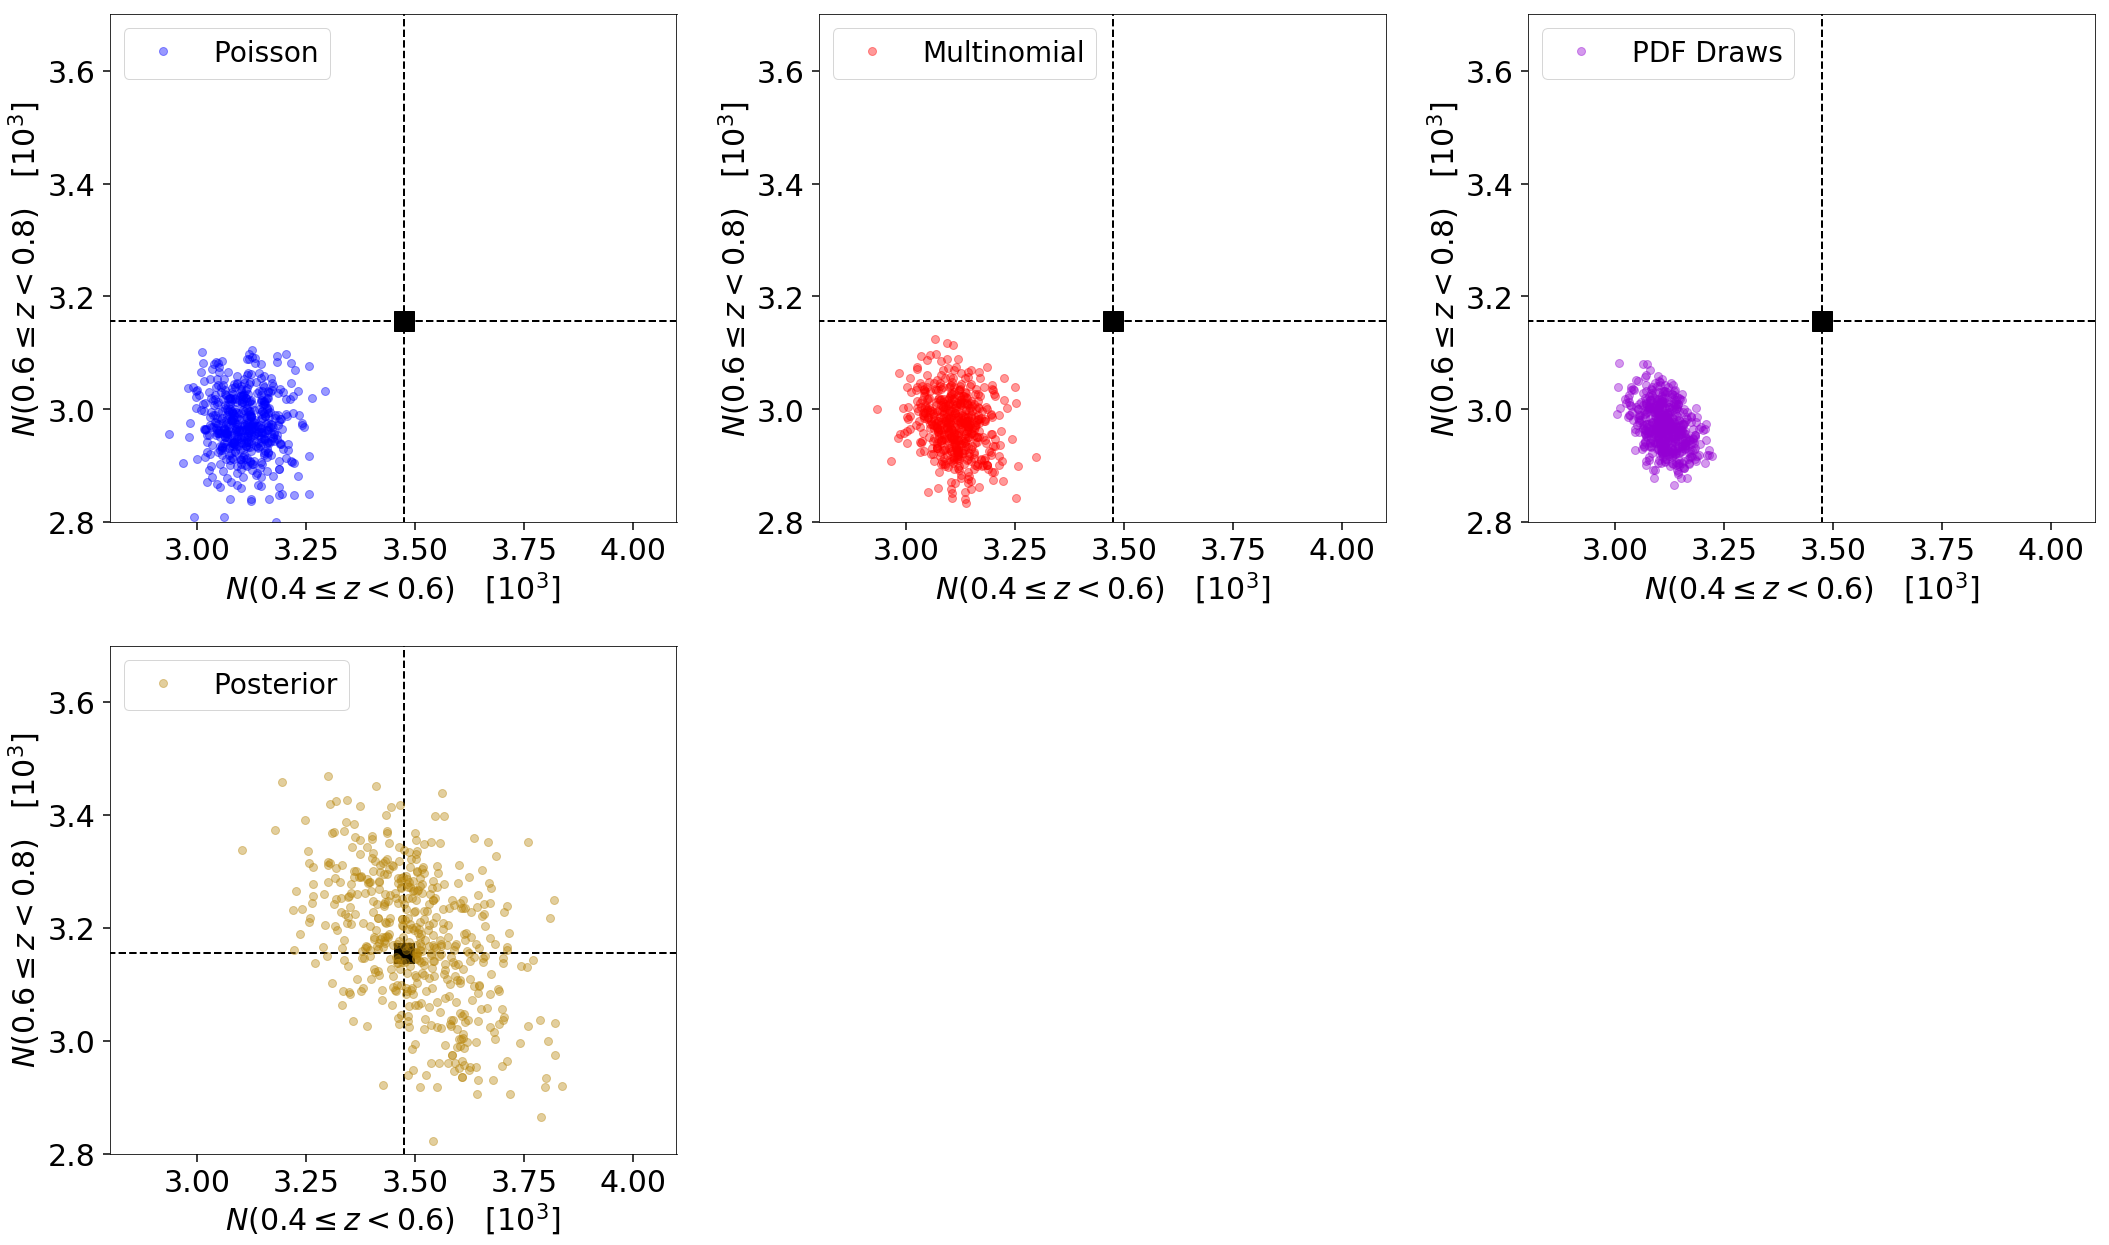

In [20]:
# plotting binned covariance
plt.figure(figsize=(30, 18))
plt.subplot(2, 3, 1)
cov_draws(pdf1_samples,
          xlim=(2.8, 4.1), ylim=(2.8, 3.7),
          color='blue', label='Poisson')
plt.subplot(2, 3, 2)
cov_draws(pdf2_samples,
          xlim=(2.8, 4.1), ylim=(2.8, 3.7),
          color='red', label='Multinomial')
plt.subplot(2, 3, 3)
cov_draws(pdf3_samples,
          xlim=(2.8, 4.1), ylim=(2.8, 3.7),
          color='darkviolet', label='PDF Draws')
plt.subplot(2, 3, 4)
cov_draws(pdf4_samples,
          xlim=(2.8, 4.1), ylim=(2.8, 3.7),
          color='darkgoldenrod', label='Posterior')

# Hierarchical Modeling

One of the issues with the approach above is that we're trying to estimate the distribution of the population $\boldsymbol{\rho}$ (i.e. the "prior") while ignoring the impact on the individual PDFs $\mathbf{p}_g$. Conceptually, the two should be linked, since our estimate of the population should better inform our guesses for each individual object. More formally, this means we want to estimate

$$
P(\boldsymbol{\rho}, \lbrace z_g \rbrace |\lbrace \mathbf{L}_g \rbrace)
$$

where $\mathbf{L}_g \equiv P(g|z) \equiv \mathcal{L}(g|z)$ is now the *likelihood* rather than the posterior. **It is extremely important that we are now conditioning on the likelihoods**: the posterior of each object already applies some (implicit) prior, and we are now interested in modeling that explicitly.

## Sampling

We can draw samples from this distribution using **Gibbs sampling** by iteratively sampling from

$$
{\rm Object\:step\!:} \quad P(\lbrace z_g' \rbrace |\lbrace \mathbf{L}_g \rbrace, \boldsymbol{\rho}') = \prod_g P(z_g' |\mathbf{p}_g')
$$

and

$$
{\rm Population\:step\!:} \quad P(\boldsymbol{\rho}' |\lbrace z_g' \rbrace, \lbrace \mathbf{L}_g \rbrace) = P(\boldsymbol{\rho}' |\lbrace z_g' \rbrace) = P(\boldsymbol{\rho}' | \mathbf{n}') \propto P(\mathbf{n}' | \boldsymbol{\rho}') P(\boldsymbol{\rho}')
$$ 

in turn.

### Object Step

The first term is straightforward: assuming independence, we are just trying to simulate the redshift to each galaxy $g$ given its PDF

$$ \mathbf{p}_g' = \frac{\mathbf{L}_g \odot \boldsymbol{\rho}'}{\mathbf{L}_g \cdot \boldsymbol{\rho}'} $$

where $\odot$ is element-wise multiplication (i.e. the Hadamard product), $\cdot$ is the dot product, and $\boldsymbol{\rho}$ is our current best guess of the prior. Since we only know whether a redshift is in a given bin, this becomes draw from the Categorical distribution:

$$ z_g' \sim \textrm{Cat}\left(\mathbf{p}_g\right) $$

### Population Step

The second term has two components. The first is the likelihood $P(\mathbf{n}'|\boldsymbol{\rho}')$, which states how likely we are to observe the set of redshifts $\lbrace z_g'\rbrace$ given our assumed population prior $\boldsymbol{\rho}'$. Using our result above, we've exploited the fact that

$$
z_g' \sim \textrm{Cat}\left(\mathbf{p}_g\right)
\quad \Leftrightarrow \quad 
\mathbf{n}_g' \sim \textrm{Mult}\left(1, \mathbf{p}_g\right)
$$

to write the collection of all the redshifts $\lbrace z_g' \rbrace$ as

$$
\mathbf{n}' = \sum_{g} \mathbf{n}_g'
$$

which is just the number of counts in each bin. Since these are just observed counts, this naturally implies that the final result is also multinomial distributed:

$$
\mathbf{n}' \sim {\rm Mult}\left(N_\mathbf{g}, \boldsymbol{\rho}'\right)
$$

Unfortunately, we are interested in $\boldsymbol{\rho}'$, not $\mathbf{n}'$. So for a given $P(\boldsymbol{\rho}')$ we'll actually have to sample $\boldsymbol{\rho}'$ from the posterior distribution analagous to our population inference case.

## Conjugate Priors

To avoid having to sample from $P(\boldsymbol{\rho}' | \mathbf{n}')$ directly, we can exploit **conjugate priors** to get the posterior in an analytic form. For this multinomial, the conjugate prior is the **Dirichlet** distribution. Taking the prior to be

$$ \boldsymbol{\rho}' \sim {\rm Dir}\left(\boldsymbol{\alpha}\right) $$

with concentration parameters $\boldsymbol{\alpha}$, for a given $\mathbf{n}'$ the posterior for $\boldsymbol{\rho}'$ becomes

$$ \boldsymbol{\rho}' \sim {\rm Dir}\left(\mathbf{n}' + \boldsymbol{\alpha}\right) $$

Assuming we have a reference set of $\mathbf{m}$ counts we've observed in a previous sample, we can apply the same logic to arrive at a modified prior

$$ \boldsymbol{\rho} \sim {\rm Dir}\left(\mathbf{m} + \boldsymbol{\alpha}\right) $$

This is straightforward to simulate from.

## Implementation

Like with our population model, `frankenz` also contains an "out-of-the-box" MCMC sampler to sampler from our hierarchical model. You can pass your own set of `alpha` values if you like; otherwise `alpha=1` is assumed.

In [21]:
# initialize sampler
sampler_hb = samplers.hierarchical_sampler(zpdf_norm)

# run HB Gibbs sampler
sampler_hb.run_mcmc(Nsamples + Nburn, alpha=alpha+counts_ref)

 Sample 600/600 [lnpost = 224.546]      

Due to the fact that we can generate samples from both of our conditional distribution analytically, the hiearchical model -- in addition to being the more "natural" model -- actually is easier (and quicker) to sampler from than the population model.

In [22]:
# grab samples
pdf5_samples, pdf5_lnps = sampler_hb.results
pdf5_samples = pdf5_samples[-500:] * Nobs  # truncate and rescale

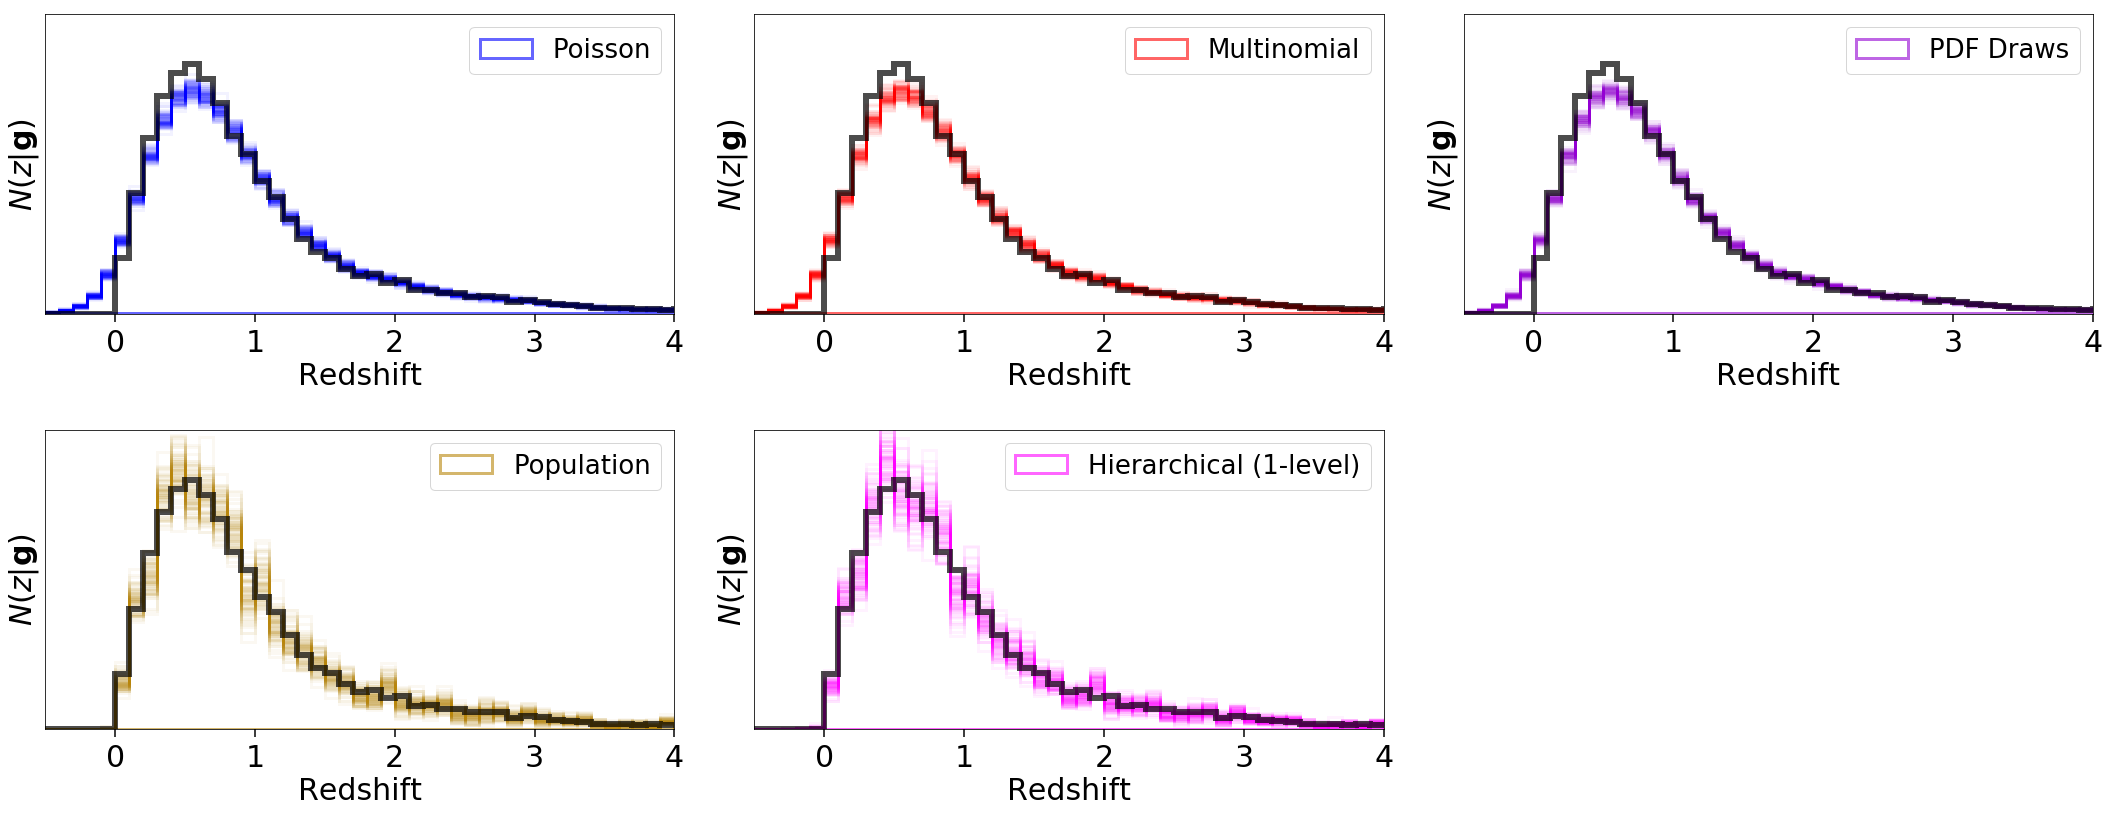

In [23]:
# plotting
plt.figure(figsize=(30, 12))
plt.subplot(2, 3, 1)
zplot_bin(pdf1_samples, label='Poisson', color='blue')
plt.subplot(2, 3, 2)
zplot_bin(pdf2_samples, label='Multinomial', color='red')
plt.subplot(2, 3, 3)
zplot_bin(pdf3_samples, label='PDF Draws', color='darkviolet')
plt.subplot(2, 3, 4)
zplot_bin(pdf4_samples, label='Population', color='darkgoldenrod')
plt.subplot(2, 3, 5)
zplot_bin(pdf5_samples, label='Hierarchical (1-level)', color='fuchsia')

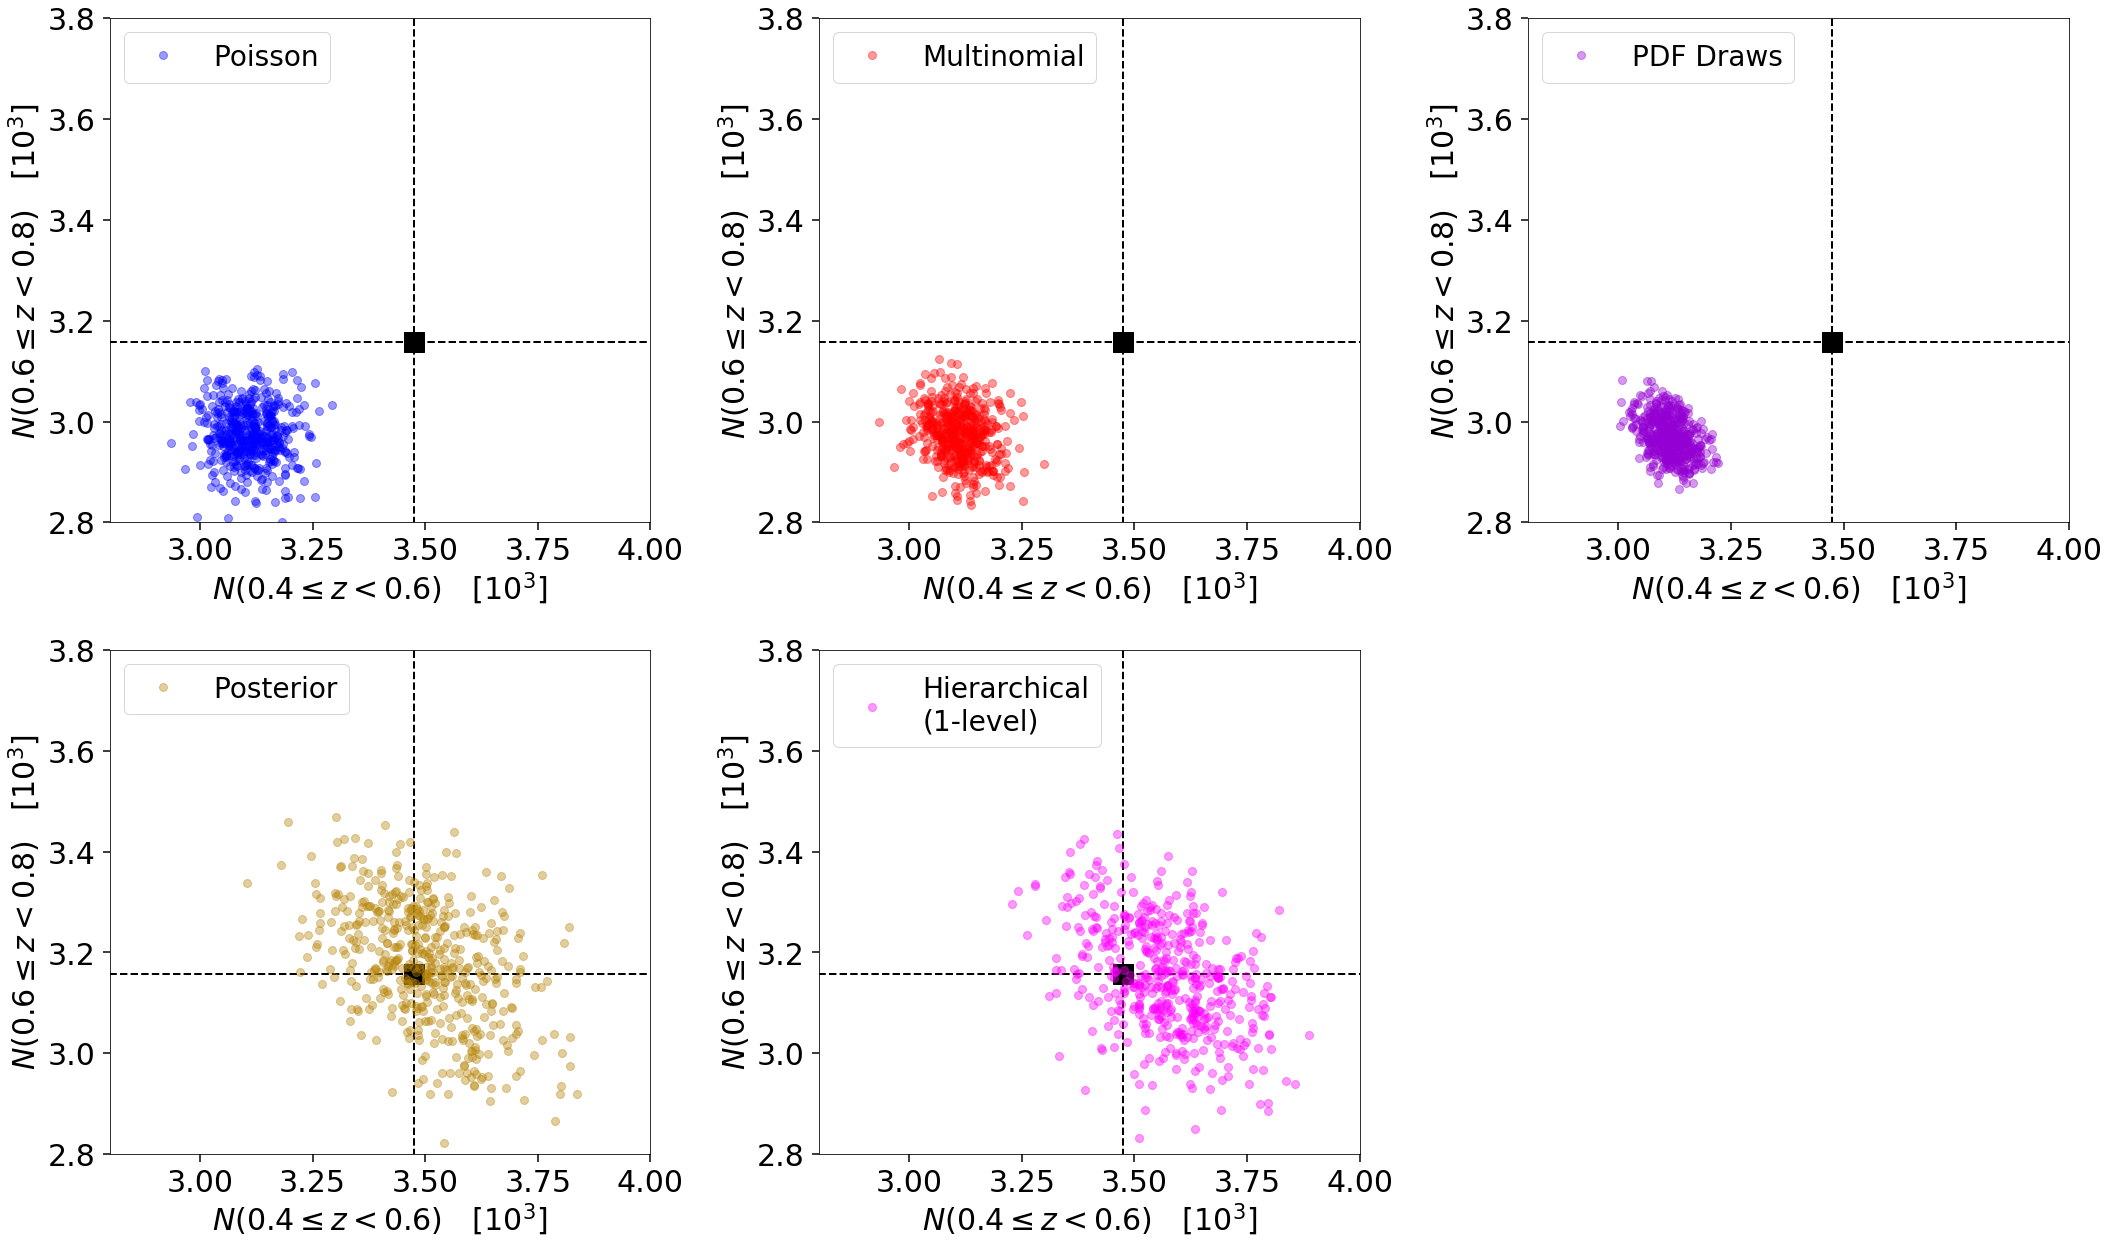

In [24]:
# plotting binned covariance
plt.figure(figsize=(30, 18))
plt.subplot(2, 3, 1)
cov_draws(pdf1_samples,
          xlim=(2.8, 4.0), ylim=(2.8, 3.8),
          color='blue', label='Poisson')
plt.subplot(2, 3, 2)
cov_draws(pdf2_samples,
          xlim=(2.8, 4.0), ylim=(2.8, 3.8),
          color='red', label='Multinomial')
plt.subplot(2, 3, 3)
cov_draws(pdf3_samples,
          xlim=(2.8, 4.0), ylim=(2.8, 3.8),
          color='darkviolet', label='PDF Draws')
plt.subplot(2, 3, 4)
cov_draws(pdf4_samples,
          xlim=(2.8, 4.0), ylim=(2.8, 3.8),
          color='darkgoldenrod', label='Posterior')
plt.subplot(2, 3, 5)
cov_draws(pdf5_samples,
          xlim=(2.8, 4.0), ylim=(2.8, 3.8),
          color='fuchsia', label='Hierarchical\n(1-level)')

## Hierarchical Shrinkage

While the above results have looked at the marginalized distribution of $\boldsymbol{\rho}$, we can use our results to generate the marginalized distributions for each of our objects $P(z|g)$. Because these apply the prior learned from the population, the individual PDFs are often better-constrained as a result. This effect is known as **hierarchical shrinkage**.

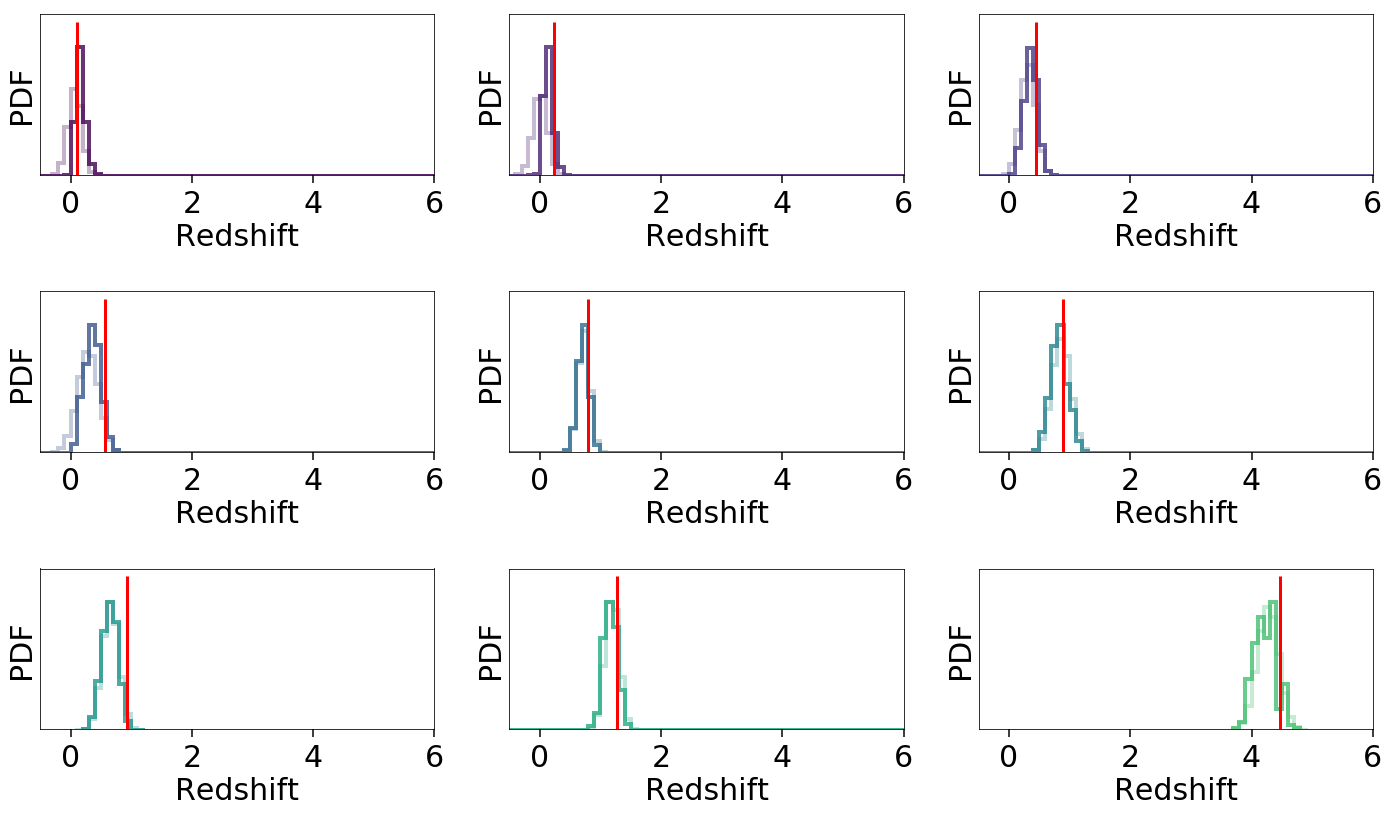

In [25]:
# plot new PDFs
plt.figure(figsize=(20, 12))
for i, (j, c) in enumerate(zip(idxs, colors)):
    plt.subplot(Nfigs[0], Nfigs[1], i + 1)
    n1, _, _ = plt.hist(zbins_mid, zbins, weights=zpdf_bins[j], 
                        color=c, lw=4, alpha=0.3, histtype='step',
                        density=True)
    zpdf_bins_t = np.sum([np.random.multinomial(10, (zpdf_bins[j] * p / 
                                                np.dot(zpdf_bins[j], p)))
                          for p in pdf5_samples], axis=0)
    n2, _, _ = plt.hist(zbins_mid, zbins, weights=zpdf_bins_t, 
                        color=c, lw=4, alpha=0.8, histtype='step',
                        density=True)
    plt.vlines(redshifts[j], 0., np.max([n1, n2]) * 1.2, color='red', 
               lw=3)
    plt.xlim([-0.5, 6])
    plt.ylim([0.03, None])
    plt.xlabel('Redshift')
    plt.yticks([])
    plt.ylabel('PDF')
    plt.tight_layout()

# Higher-Level Model

One issue the above models have is that they assume that we have a "representative" reference sample. What happens in the case where we think our reference sample might be unrepresentative? Well, then we can pretend we have a "virtual" reference set with counts $\mathbf{k}'$ and add in a third step to our model:

$$
{\rm Reference\:step\!:} \quad P(\mathbf{k}' |\boldsymbol{\rho}', \lbrace z_g' \rbrace, \lbrace \mathbf{L}_g \rbrace) = P(\mathbf{k}' | \boldsymbol{\rho}')
$$ 

Sampling from this turns out to be relatively straightforward:

$$
\mathbf{k}' \sim {\rm Mult}\left(N_{\rm ref}, \frac{\mathbf{m} + \boldsymbol{\beta} + N_\mathbf{g} \boldsymbol{\rho}'}{N_{\rm ref} + N_{\boldsymbol{\beta}} + N_\mathbf{g}}\right)
$$

where $\boldsymbol{\beta}$ comes from another Dirichlet hyper-prior which we by default take to be $1$.

We then use our "virtual" reference counts $\mathbf{k}'$ in the remainder of the sampling phases

This now represents a compromise between the reference sample we observed and the distribution constrained by our data. In the case where $N_{\rm ref} \gg N_\mathbf{g}$, this means $\mathbf{k}$ will just include possible multinomial sampling error. In the case where $N_\mathbf{g} \gg N_{\rm ref}$, this will reduce to applying random sampling from our estimated $\boldsymbol{\rho}$ and will have minimal impact on the analysis.

We can sample with this additional step by passing the reference counts to `ref_sample` when sampling.

In [26]:
beta = np.ones(Nbins)

# run HB Gibbs sampler w/ explicit reference set
sampler_hb2 = samplers.hierarchical_sampler(zpdf_norm)
sampler_hb2.run_mcmc(Nsamples + Nburn, alpha=alpha, ref_sample=counts_ref, beta=beta)

 Sample 600/600 [lnpost = -1.757]       

Due to the fact that we can generate samples from both of our conditional distribution analytically, the hiearchical model -- in addition to being the more "natural" model -- actually is easier (and quicker) to sampler from than the population model.

In [27]:
# grab samples
pdf6_samples, pdf6_lnps = sampler_hb2.results
pdf6_samples = pdf6_samples[-500:] * Nobs  # truncate and rescale

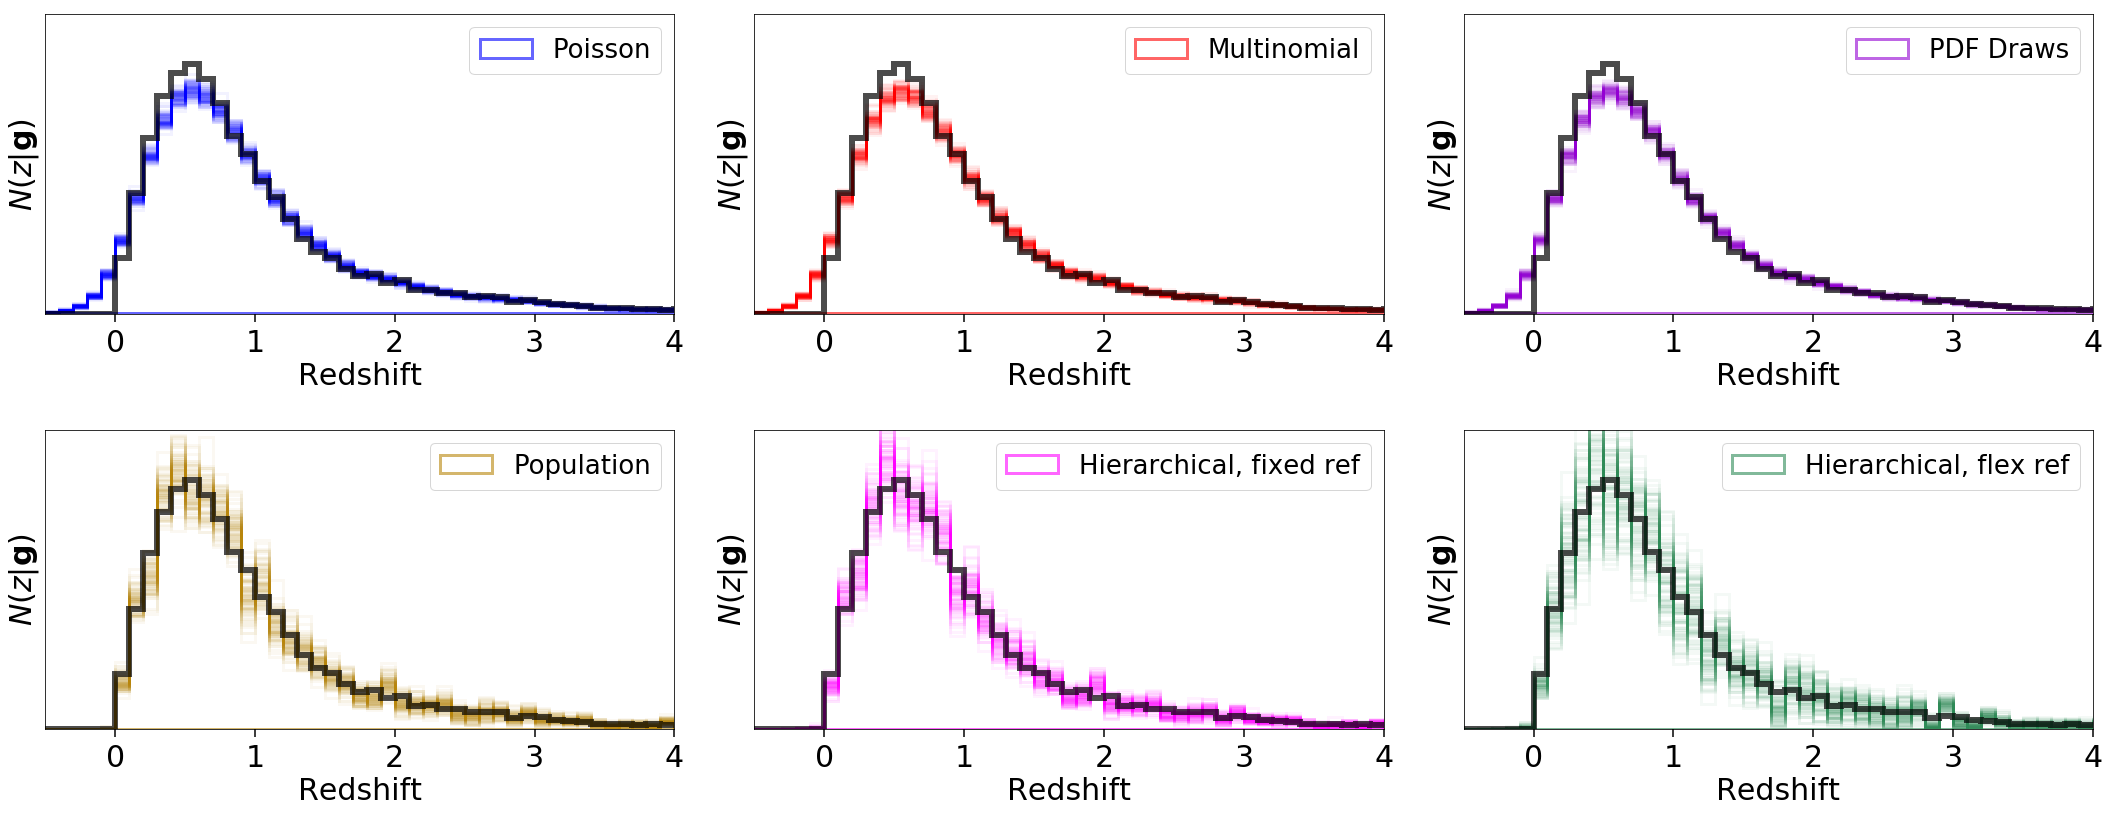

In [28]:
# plotting
plt.figure(figsize=(30, 12))
plt.subplot(2, 3, 1)
zplot_bin(pdf1_samples, label='Poisson', color='blue')
plt.subplot(2, 3, 2)
zplot_bin(pdf2_samples, label='Multinomial', color='red')
plt.subplot(2, 3, 3)
zplot_bin(pdf3_samples, label='PDF Draws', color='darkviolet')
plt.subplot(2, 3, 4)
zplot_bin(pdf4_samples, label='Population', color='darkgoldenrod')
plt.subplot(2, 3, 5)
zplot_bin(pdf5_samples, label='Hierarchical, fixed ref', color='fuchsia')
plt.subplot(2, 3, 6)
zplot_bin(pdf6_samples, label='Hierarchical, flex ref', color='seagreen')

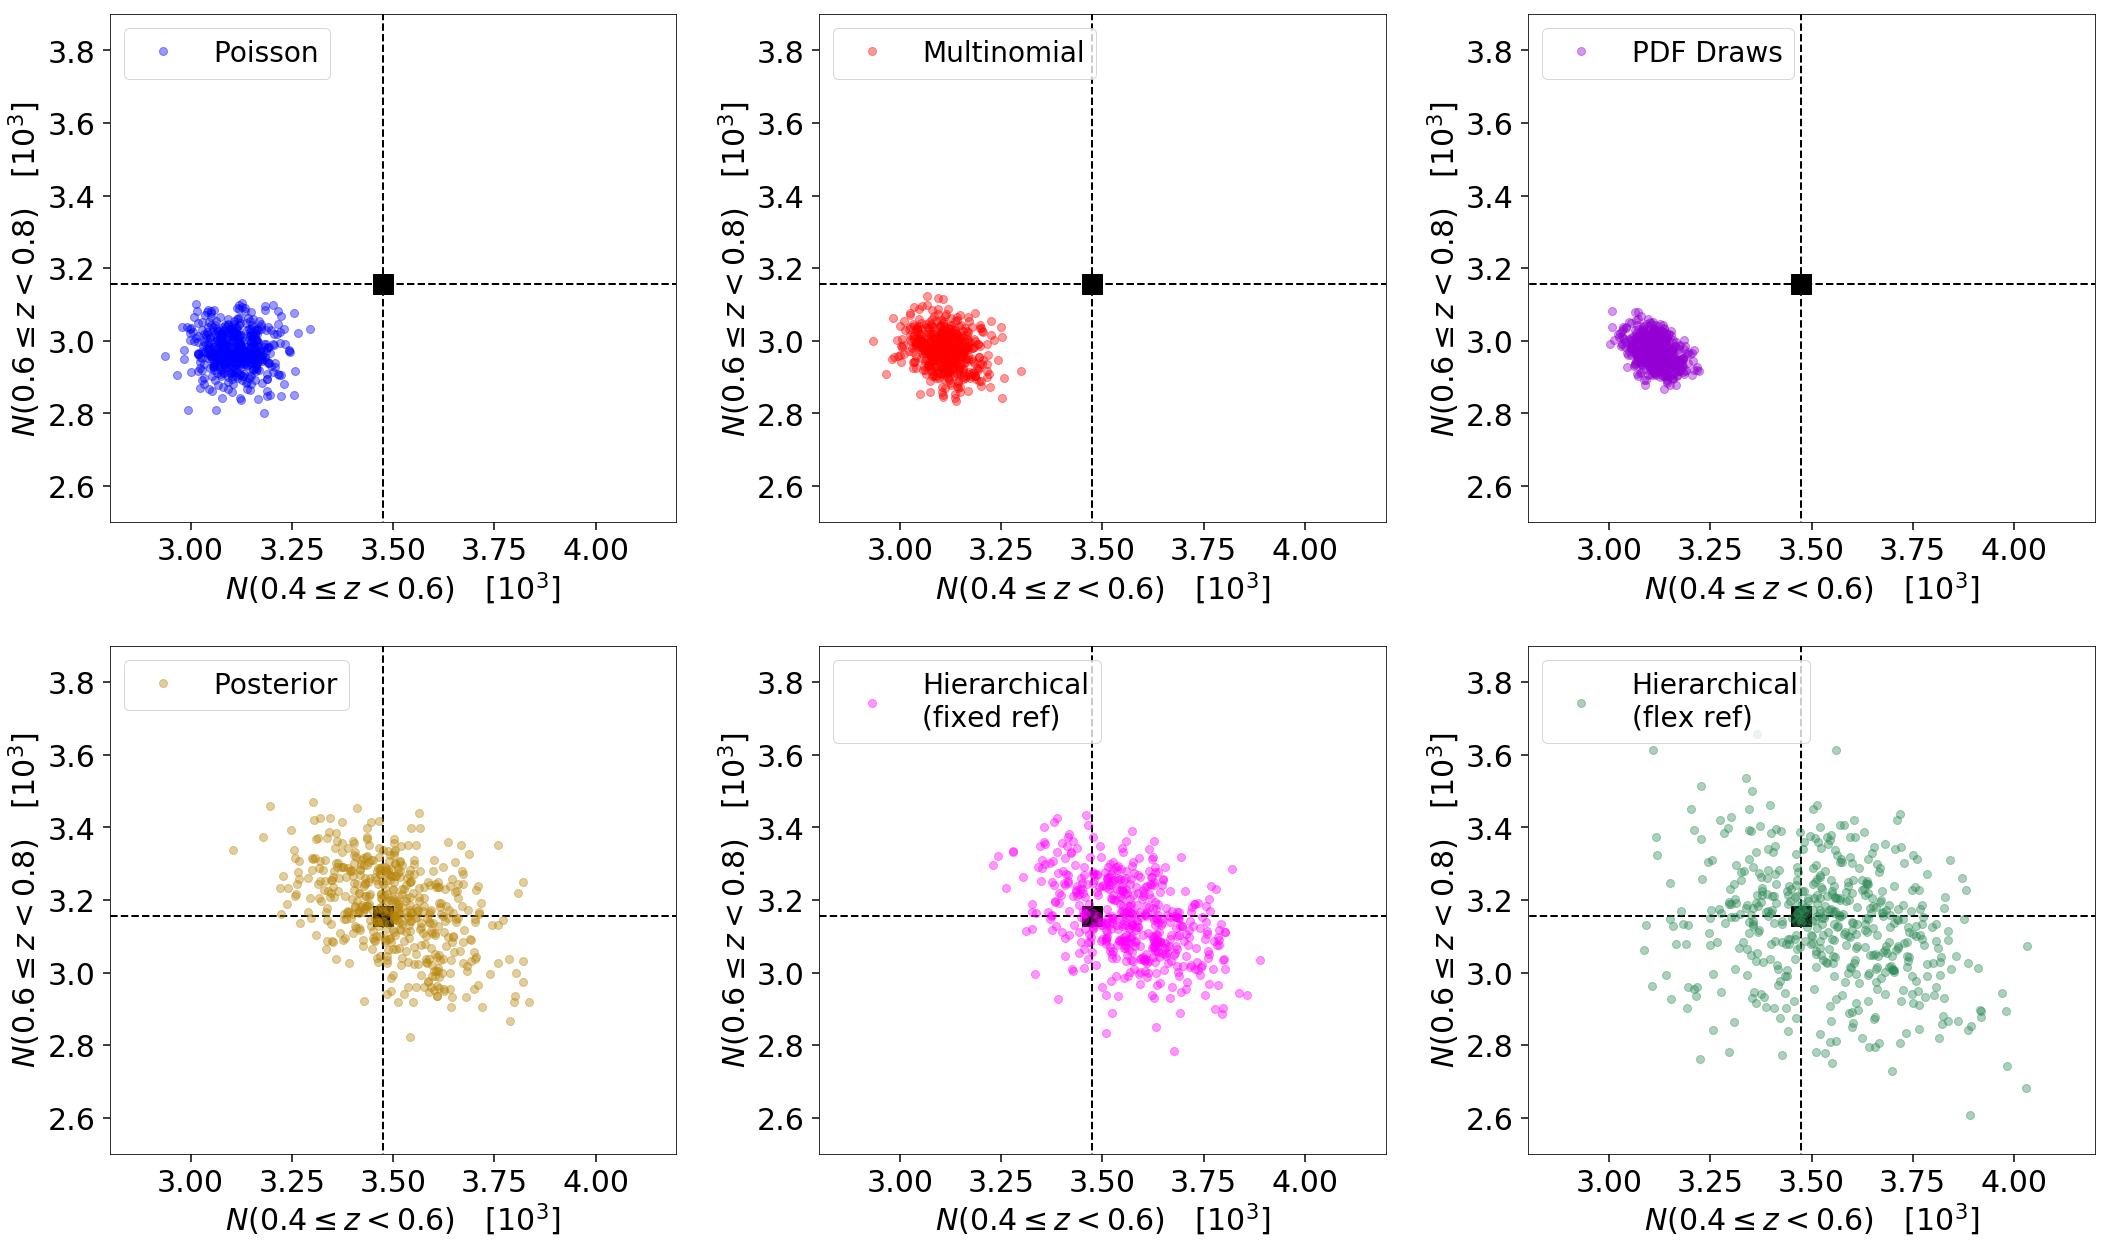

In [32]:
# plotting binned covariance
plt.figure(figsize=(30, 18))
plt.subplot(2, 3, 1)
cov_draws(pdf1_samples,
          xlim=(2.8, 4.2), ylim=(2.5, 3.9),
          color='blue', label='Poisson')
plt.subplot(2, 3, 2)
cov_draws(pdf2_samples,
          xlim=(2.8, 4.2), ylim=(2.5, 3.9),
          color='red', label='Multinomial')
plt.subplot(2, 3, 3)
cov_draws(pdf3_samples,
          xlim=(2.8, 4.2), ylim=(2.5, 3.9),
          color='darkviolet', label='PDF Draws')
plt.subplot(2, 3, 4)
cov_draws(pdf4_samples,
          xlim=(2.8, 4.2), ylim=(2.5, 3.9),
          color='darkgoldenrod', label='Posterior')
plt.subplot(2, 3, 5)
cov_draws(pdf5_samples,
          xlim=(2.8, 4.2), ylim=(2.5, 3.9),
          color='fuchsia', label='Hierarchical\n(fixed ref)')
plt.subplot(2, 3, 6)
cov_draws(pdf6_samples,
          xlim=(2.8, 4.2), ylim=(2.5, 3.9),
          color='seagreen', label='Hierarchical\n(flex ref)')

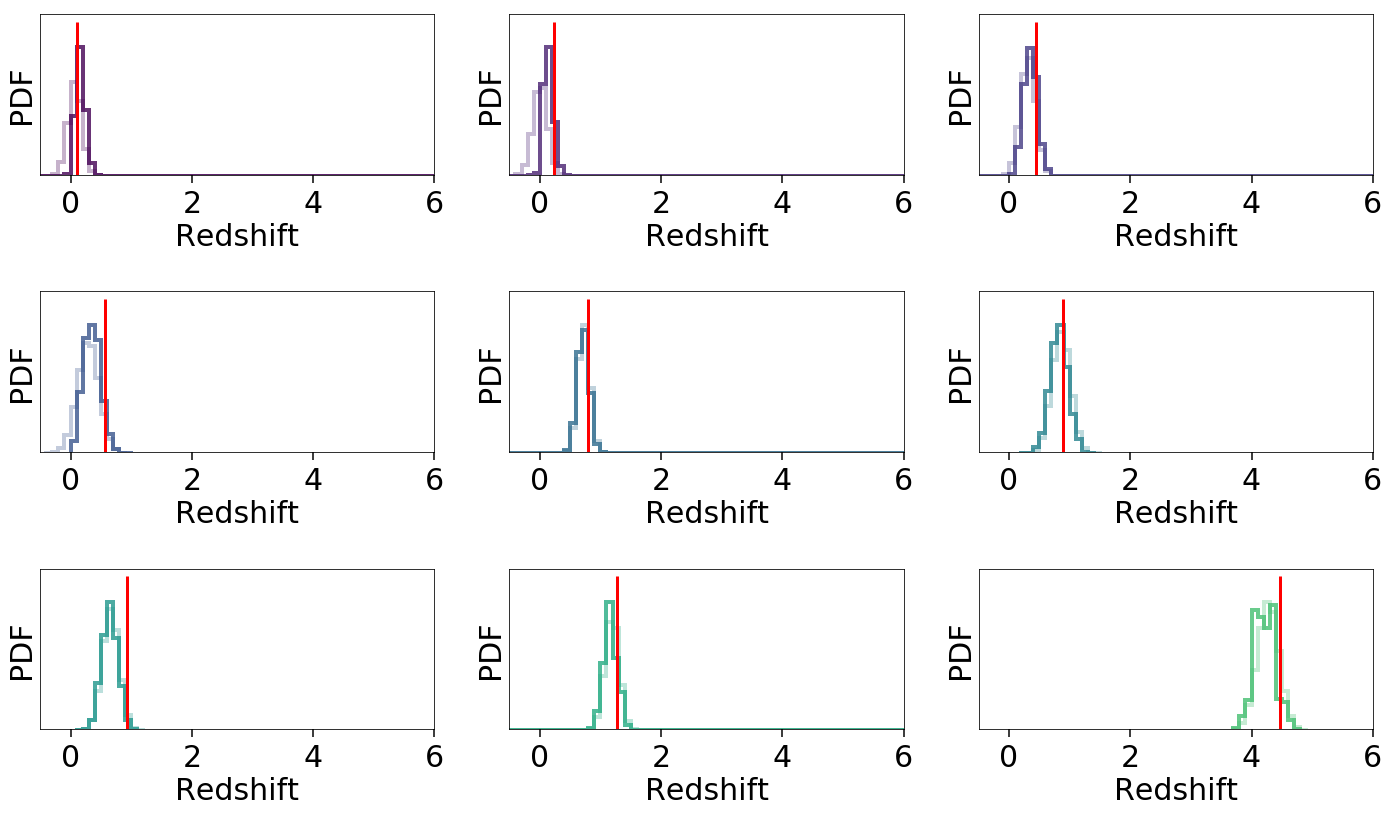

In [33]:
# plot new PDFs
plt.figure(figsize=(20, 12))
for i, (j, c) in enumerate(zip(idxs, colors)):
    plt.subplot(Nfigs[0], Nfigs[1], i + 1)
    n1, _, _ = plt.hist(zbins_mid, zbins, weights=zpdf_bins[j], 
                        color=c, lw=4, alpha=0.3, histtype='step',
                        density=True)
    zpdf_bins_t = np.sum([np.random.multinomial(10, (zpdf_bins[j] * p / 
                                                np.dot(zpdf_bins[j], p)))
                          for p in pdf6_samples], axis=0)
    n2, _, _ = plt.hist(zbins_mid, zbins, weights=zpdf_bins_t, 
                        color=c, lw=4, alpha=0.8, histtype='step',
                        density=True)
    plt.vlines(redshifts[j], 0., np.max([n1, n2]) * 1.2, color='red', 
               lw=3)
    plt.xlim([-0.5, 6])
    plt.ylim([0.03, None])
    plt.xlabel('Redshift')
    plt.yticks([])
    plt.ylabel('PDF')
    plt.tight_layout()

As we expect, this higher-level model where we allow the reference set to vary based on our estimates of the population increases the uncertainty in our inference.